# Project

The goal of the is to build a data pipline around newspaper article data, include some non-trivial ML based functionality in python.
I decided to do sentiment analysis and thereby predict the sentiment of newspaper articles.

To train a sentiment classification I need labeled training data. As I want to predict the sentiment of german newspaper articles, I need german text.
The only good labeled dataset that I found was from Oliver Guhr ("https://github.com/oliverguhr/german-sentiment"). But as we should practice data scraping during this project I couldn't just load the preprocessed data. That is why I decided to pick the movie review website "filmstarts.de" and scrape movie ratings. Based on the rating of a movie, I then classify the text as positive or negative sentiment. Therefore, I get labeled text data. Unfortunately filmstarts has no api where you can easily fetch the data from. Also, I couldn't find a python package or code from github which already solved fetching tasks from filmstarts. That was quite a bummer, thus I had to create my own scraping using beautifulsoup4.

Fortunately, the website of "filmstarts.de" is good structured. In the base url "https://www.filmstarts.de/kritiken/neuste-kritiken/" all the latest reviews are added. The website also implemented pagination in the url query parameters as "?page=123". Thereby I can easily loop over the pages. In each page I had to extract the movie IDs. That was also easily solved, as all the movie IDs are links with a specific class (class_="meta-title-link"). After getting the movie IDs I could directly jump to the full review page and skip one "click" by accessing the url via "https://www.filmstarts.de/kritiken/neuste-kritiken/MOVIE_ID/kritik.html".
 Now I had to parse the actual review text. That was more complicated than I thought. The review text is not in one paragraph, it is seperated in all different kinds of html tags, has pictures in between blocks and advertisements as well. That is why I had to create an allow_list of html tags (['p', 'div', 'a', 'i', 'strong']) and block_class_list for html classes to only get the relevant data.
Next I scraped also the name of the movie as well as the review score. Last, I cleaned the text by removing punctuation chars and other special chars like new lines.

As the final data structure, I created a dictionary including the following elements, and saved the scraped movies as csv, as the scraping took 3 hours.
* name
* rating
* words
* characters
* text

In [1]:
from bs4 import BeautifulSoup, NavigableString, Tag
import requests
import pandas as pd

url_base = 'https://www.filmstarts.de'
url_reviews = 'https://www.filmstarts.de/kritiken/neuste-kritiken/'


def set_to_review_url(movie_url):
    return url_base + movie_url[:-5] + '/kritik.html'


def parse_review_text(review_elements):
    text_elements = []
    allowlist = ['p', 'div', 'a', 'i', 'strong']
    block_class_list = ['video-card-player', 'article-figure-holder']
    for element in review_elements:
        if isinstance(element, NavigableString):
            text_elements.append(element.text)
        elif isinstance(element, Tag):
            if element.has_attr('class') and element['class'][0] not in block_class_list:
                text_elements.append(element.text)
            if not element.has_attr('class'):
                text_elements.append(element.text)
    return ''.join(text_elements).replace(u'\xa0', u' ').replace(u'\n', u'').strip()


def get_movies_in_page(page_url, modify_url_function):
    movie_urls = []
    page = requests.get(page_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    movies = soup.find_all("a", class_="meta-title-link", href=True)
    for movie in movies:
        movie_urls.append(modify_url_function(movie['href']))
    return movie_urls


def extract_review_information(review_url, parse_review_text):
    review = requests.get(review_url)
    soup = BeautifulSoup(review.text, 'html.parser')
    rating = soup.find("span", class_="note").getText()
    name = soup.find("div", class_="title").getText()
    text = parse_review_text(soup.find("div", class_="editorial-content cf"))
    cleaned_text = remove_punctuation(text)
    return {'name': name.replace(u'\n', u'').strip(),
            'rating': float(rating.replace(',', '.')),
            'words': len(cleaned_text.split()),
            'characters': len(cleaned_text),
            'text': cleaned_text}


def get_page_url(page_number):
    return 'https://www.filmstarts.de/kritiken/neuste-kritiken/?page=' + str(page_number)


def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', '„', '“', '(', ')', ',', '–'))
    return final


# currently page 1-722 available
last_page = 722
scraped_movies = []
for page in range(1, last_page + 1):
    try:
        print('current processed page: ' + str(page))
        movie_list_in_page = get_movies_in_page(get_page_url(page), set_to_review_url)
        for movie in movie_list_in_page:
            try:
                scraped_movies.append(extract_review_information(movie, parse_review_text))
                # checkpoints
                if len(scraped_movies) % 100 == 0:
                    pd.DataFrame(scraped_movies).to_csv('scraped_movies.csv', encoding='utf-8-sig')
            except:
                print('movie error')
                pass
    except:
        print('page error')
        pass
    # final save
pd.DataFrame(scraped_movies).to_csv('scraped_movies.csv', encoding='utf-8-sig')

current processed page: 1
current processed page: 2
current processed page: 3
current processed page: 4
current processed page: 5
current processed page: 6
current processed page: 7
current processed page: 8
current processed page: 9
current processed page: 10
current processed page: 11
current processed page: 12
current processed page: 13
current processed page: 14
current processed page: 15
current processed page: 16
current processed page: 17
current processed page: 18
current processed page: 19
current processed page: 20
current processed page: 21
current processed page: 22
current processed page: 23
current processed page: 24
current processed page: 25
current processed page: 26
current processed page: 27
current processed page: 28
current processed page: 29
current processed page: 30
current processed page: 31
current processed page: 32
current processed page: 33
current processed page: 34
current processed page: 35
current processed page: 36
current processed page: 37
current pr

Next I also scraped the newspaper articles with the given code from the lecture. I added the same cleaning steps as I did in my own movie review scraping and also added the "words" and "characters" in the article information.

In [2]:
import newspaper
import pandas as pd

news_websites = ['https://welt.de','https://www.spiegel.de/']  #,
scraped_articles = []

counter = 1
for news_website in news_websites:
    news = newspaper.build(news_website)
    for article in news.articles:
        try:
            article.download()
            article.parse()
            cleaned_text = remove_punctuation(article.text)
            scraped_articles.append({
                'newspaper': news_website,
                'url': article.url,
                'title': article.title,
                'words': len(cleaned_text.split()),
                'characters': len(cleaned_text),
                'text': cleaned_text
            })
            print("article downloaded count: " + str(counter))
            counter += 1
            # checkpoint
            if len(scraped_articles) % 100 == 0:
                pd.DataFrame(scraped_articles).to_csv('scraped_articles.csv', encoding='utf-8-sig')
        except:
            #print('you better check this error')
            pass
# final save
pd.DataFrame(scraped_articles).to_csv('scraped_articles.csv', encoding='utf-8-sig')

article downloaded count: 1
article downloaded count: 2
article downloaded count: 3
article downloaded count: 4
article downloaded count: 5
article downloaded count: 6
article downloaded count: 7
article downloaded count: 8
article downloaded count: 9
article downloaded count: 10
article downloaded count: 11
article downloaded count: 12
article downloaded count: 13
article downloaded count: 14
article downloaded count: 15
article downloaded count: 16
article downloaded count: 17
article downloaded count: 18
article downloaded count: 19
article downloaded count: 20
article downloaded count: 21
article downloaded count: 22
article downloaded count: 23
article downloaded count: 24
article downloaded count: 25
article downloaded count: 26
article downloaded count: 27
article downloaded count: 28
article downloaded count: 29
article downloaded count: 30
article downloaded count: 31
article downloaded count: 32
article downloaded count: 33
article downloaded count: 34
article downloaded coun

reload the already scraped articles and movies

In [2]:
import pandas as pd
articles =pd.read_csv('scraped_articles_repo.csv')
movies =pd.read_csv('scraped_movies_repo.csv')
print('movie count: '+ str(len(movies)))
print('articles count: '+ str(len(articles)))

movie count: 10829
articles count: 887


## Data Analyzing and Sentiment Class creation
Nextup, I took a look at the data I scraped.
First, I scraped 10829 movie reviews and 887 articles.

Second, I wanted to see how the review scores are distributed. That i important as it will influence the available training/test data for the positive and the negative sentiments. The review scores are a bit skewed to the right, with the most rating of 3.5 (2358).

Next, I also look how the word counts of the reviews are distributed. They are normally distributed with an average of 720-740 words per review.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

fig = px.histogram(movies, x="rating")
fig.update_traces(marker_color="turquoise", marker_line_color='rgb(8,48,107)',marker_line_width=1)
fig.update_layout(title_text='Movie Review Scores')
fig.write_image('./figs/review_scores_distribution.png')
fig.show()

In [4]:
fig = px.histogram(movies, x="words")
fig.update_traces(marker_color="turquoise", marker_line_color='rgb(8,48,107)',marker_line_width=1)
fig.update_layout(title_text='Movie Review words')
fig.write_image('./figs/review_words_distribution.png')
fig.show()

Next I took a look of the most used words in the movie reviews. I created a Movie cloud for that. After the first figure, I noticed that most of them are not interesting, as they are the most used german words in any kind of text. The so called "stopwords". Therefore, I created a second word cloud without the stop words.
The most used words are "Film", "immer", "Leben", "schon", "mehr", "dabei", "gibt", which also could be considered as stopwords. However, we have also interesting words like "Figuren", "Zuschauer", "Geschichte", "Regisseur" and "Ende", which really show that we are dealing with movie ratings.

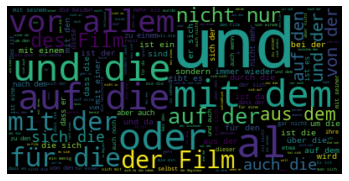

In [5]:
from wordcloud import WordCloud
all_review_text = " ".join(review for review in movies.text)
wordcloud = WordCloud().generate(all_review_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('./figs/wordcloud_reviews_with_stopwords.png')
plt.show()

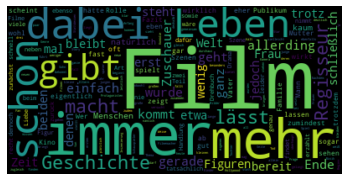

In [6]:
from nltk.corpus import stopwords
german_stop_words = stopwords.words('german')
all_review_text = " ".join(review for review in movies.text)
wordcloud = WordCloud(stopwords=german_stop_words).generate(all_review_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('./figs/wordcloud_reviews_without_stopwords.png')
plt.show()

Next, I create my training labels for positive and the negative sentiments. I decided to treat every movie review with a rating of >3 as a positive review (and also positive sentiment) and every movie review with a rating of =<3 as a negative review (negative sentiment). That way we get around 5450 positive labels and 5379 negative labels.

In [9]:
movies['binarylabel'] = movies['rating'].apply(lambda rating: +1 if rating > 3 else 0)
movies.loc[movies['binarylabel'] == 0, 'sentiment'] = 'negative'
movies.loc[movies['binarylabel'] == 1, 'sentiment'] = 'positive'
fig = px.histogram(movies, x="sentiment")
fig.update_traces(marker_color="indianred", marker_line_color='rgb(8,48,107)',marker_line_width=1.5)
fig.update_layout(title_text='Movie Review Sentiment')
fig.write_image('./figs/review_sentiment_binary_distribution.png')
fig.show()

## Training

First I split my scraped movie reviews into a training and a test dataset, ratio 80% / 20%.

In [71]:
import numpy as np
index = movies.index
movies['random_number'] = np.random.randn(len(index))
train = movies[movies['random_number'] <= 0.8]
test = movies[movies['random_number'] > 0.8]

In [72]:
train.head()

,Unnamed: 0,name,rating,words,characters,text,binarylabel,sentiment,random_number,binarylabel2,sentiment2
0,0,Überredung,3.5,890,6040,Was macht eine gute Buchadaption aus Anhand de...,1,positive,0.399337,neutral,neutral
1,1,Spiral - Das Ritual,2.5,668,4602,Bei Filmen wie Spiral Das Ritual gerät man al...,0,negative,0.309062,neutral,neutral
2,2,Thor 4: Love And Thunder,3.0,1000,6724,Extrem-Schauspieler und Oscar-Gewinner Christi...,0,negative,0.440398,neutral,neutral
3,3,Bibi & Tina - Einfach Anders,3.5,1132,7939,Der Kassetten-Ableger der Bibi Blocksberg-Reih...,1,positive,0.504073,neutral,neutral
4,4,Liebesdings,2.0,1001,6879,Filme über Superstars die sich Hals über Kopf ...,0,negative,-1.768034,negative,negative


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

sentiment_classifier = Pipeline([('vect', TfidfVectorizer(stop_words=german_stop_words)),
                                 ('clas', RandomForestClassifier())])

X_train = train['text']
y_train = train['sentiment']

sentiment_classifier.fit(X_train, y_train)

y_train_predictions = sentiment_classifier.predict(X_train)

print(confusion_matrix(y_train, y_train_predictions))
print(f1_score(y_train, y_train_predictions, pos_label="positive"))

[[4229    0]
 [   0 4245]]
1.0


In [74]:
X_test = test['text']
y_test = test['sentiment']
y_test_predictions = sentiment_classifier.predict(X_test)
print(confusion_matrix(y_test, y_test_predictions))
print(f1_score(y_test, y_test_predictions, pos_label="positive"))

[[966 184]
 [483 722]]
0.6840360018948365


In [75]:
def sentimentcolumn(row):
    if row['rating'] <= 2:
        return 'negative'
    elif row['rating'] >= 4:
        return 'positive'
    else:
        return 'neutral'

movies['sentiment2'] = movies.apply(sentimentcolumn, axis=1)

movies_pos_neg = movies[movies['sentiment2'] != 'neutral']
print(len(movies_pos_neg))
index = movies_pos_neg.index
movies_pos_neg['random_number'] = np.random.randn(len(index))
train = movies_pos_neg[movies_pos_neg['random_number'] <= 0.8]
test = movies_pos_neg[movies_pos_neg['random_number'] > 0.8]

X_train = train['text']
y_train = train['sentiment2']

sentiment_classifier.fit(X_train, y_train)

y_train_predictions = sentiment_classifier.predict(X_train)
print(confusion_matrix(y_train, y_train_predictions))
print(f1_score(y_train, y_train_predictions, pos_label="positive"))


5167


C:\Users\henninta\AppData\Local\Temp\ipykernel_15028\2589321704.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[[1618    0]
 [   0 2441]]
1.0


In [76]:
X_test = test['text']
y_test = test['sentiment2']
y_test_predictions = sentiment_classifier.predict(X_test)
print(confusion_matrix(y_test, y_test_predictions))
print(f1_score(y_test, y_test_predictions, pos_label="positive"))

[[364  93]
 [ 72 579]]
0.8752834467120182


https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python



I also could overwrite the default score() function of every model and use the F1 score as a default.
The RandomForestClassifier e.g. uses the "Mean accuracy" and that is not the best metric as it can give good results in e.g a unbalanced dataset event if the model performs really poorly.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.score



In [66]:
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score

class ClfSwitcher(BaseEstimator):
    def __init__(
        self,
        estimator = RandomForestClassifier(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    # def score(self, X, y):
    #     return self.estimator.score(X, y, ) #score

    def score(self, X, y):
        y_pred = self.estimator.predict(X)
        return f1_score(y, y_pred, pos_label="positive")

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=german_stop_words)),
    ('clf', ClfSwitcher()),
])

parameters = [
    # {
    #     'clf__estimator': [SGDClassifier()],
    #     #'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
    #     #'clf__estimator__max_iter': [50, 80],
    #     #'clf__estimator__tol': [1e-4],
    #     #'clf__estimator__loss': ['hinge', 'log', 'modified_huber'],
    # },
    {
        'clf__estimator': [RandomForestClassifier()],
        #'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
    },
        {
        'clf__estimator': [LogisticRegression()],
        #'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
    }


]

gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, return_train_score=True)
gscv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['aber',
                                                                    'alle',
                                                                    'allem',
                                                                    'allen',
                                                                    'aller',
                                                                    'alles',
                                                                    'als',
                                                                    'also',
                                                                    'am', 'an',
                                                                    'ander',
                                                                    'andere',
                                                                    'anderem',
       

In [68]:
print(gscv.cv_results_)

{'mean_fit_time': array([8.61559]), 'std_fit_time': array([0.13975229]), 'mean_score_time': array([0.79485025]), 'std_score_time': array([0.10605206]), 'param_clf__estimator': masked_array(data=[RandomForestClassifier()],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'clf__estimator': RandomForestClassifier()}], 'split0_test_score': array([0.85744456]), 'split1_test_score': array([0.85171103]), 'split2_test_score': array([0.86918919]), 'split3_test_score': array([0.88610039]), 'split4_test_score': array([0.8925144]), 'mean_test_score': array([0.87139191]), 'std_test_score': array([0.01580643]), 'rank_test_score': array([1]), 'split0_train_score': array([1.]), 'split1_train_score': array([1.]), 'split2_train_score': array([1.]), 'split3_train_score': array([1.]), 'split4_train_score': array([1.]), 'mean_train_score': array([1.]), 'std_train_score': array([0.])}


In [69]:
print(gscv.cv_results_['mean_train_score'])
print(gscv.cv_results_['mean_test_score'])

[1.]
[0.87139191]


In [70]:
print(gscv.best_params_)

{'clf__estimator': RandomForestClassifier()}


In [83]:
article_sentiment_prediction = sentiment_classifier.predict(articles['text'])
unique, counts = np.unique(article_sentiment_prediction, return_counts=True)
print(np.asarray((unique, counts)).T)

[['negative' 10]
 ['positive' 877]]


In [104]:
probabilities_pos = pd.DataFrame(sentiment_classifier.predict_proba(articles['text'])[:,1], columns=['prob_pos'])
probabilities_pos.sort_values(by='prob_pos',ascending=False, inplace=True)
probabilities_pos

,prob_pos
307,1.00
812,1.00
314,1.00
308,1.00
418,0.99
...,...
458,0.48
472,0.47
325,0.46
332,0.44


In [107]:
articles.iloc[probabilities_pos.iloc[0:5].index]

,Unnamed: 0,newspaper,url,title,words,characters,text
307,307,https://welt.de,https://welt.de/sport/video239847343/DFB-Torhu...,DFB-Torhüterin: Frohms „überrascht“ von riesig...,28,228,Nationaltorhüterin Merle Frohms hat sich nach ...
812,812,https://www.spiegel.de/,https://www.spiegel.de/auto/toyota-mirai-im-te...,Toyota Mirai im Test: Brennstoffzelle statt Ba...,21,159,Merkliste Dialog schließen\n\nSpeichern Sie Ih...
314,314,https://welt.de,https://welt.de/politik/deutschland/video23988...,Energiekrise: Private Haushalte müssen auch „i...,20,122,Alle Deals\n\nPrime Day\n\nBei diesen Angebote...
308,308,https://welt.de,https://welt.de/sport/video239847297/Rassismus...,Rassismus und Sexismus: Fan-Skandal überschatt...,34,255,Der Große Preis von Österreich ist von zahlrei...
418,418,https://welt.de,https://welt.de/politik/ausland/video239900059...,US-Präsident: Biden besucht den Nahen Osten,30,187,Israel ist einer der engsten Verbündeten der U...


In [91]:
pd_article_sentiment_prediction = pd.DataFrame(article_sentiment_prediction, columns=['pred'])
negative_preds = pd_article_sentiment_prediction.loc[pd_article_sentiment_prediction['pred']=='negative']
negative_preds

,pred
8,negative
108,negative
223,negative
325,negative
332,negative
458,negative
472,negative
473,negative
557,negative
715,negative


In [94]:
articles.iloc[negative_preds.index]

,Unnamed: 0,newspaper,url,title,words,characters,text
8,8,https://welt.de,https://welt.de/debatte/kommentare/article2398...,"Nord Stream 1: Es reicht nicht, dass Habeck nu...",512,3416,Im Umgang mit Russland muss Deutschland sich a...
108,108,https://welt.de,http://www.welt.de/wirtschaft/article239907635...,Zugunglück in Garmisch: Bahn prüft rund 200.00...,438,3227,Das schwere Bahnunglück in Oberbayern Anfang J...
223,223,https://welt.de,https://welt.de/wirtschaft/article239907635/Zu...,Zugunglück in Garmisch: Bahn prüft rund 200.00...,438,3227,Das schwere Bahnunglück in Oberbayern Anfang J...
325,325,https://welt.de,https://welt.de/kultur/article239671701/Autos-...,Autos im Kino und die „Letzte Generation“,362,2490,Autos haben gerade keinen guten Ruf Von der Le...
332,332,https://welt.de,https://welt.de/kultur/article239716907/Sophie...,Sophie Passmann: Das verrät „Damaged Goods“ üb...,811,5717,Seit Jahren kann man Sophie Passmann kaum entk...
458,458,https://welt.de,https://welt.de/newsticker/dpa_nt/infoline_nt/...,Vingegaard fährt Pogacar aus dem Gelben Trikot,673,4267,Superstar Tadej Pogacar erleidet auf der elfte...
472,472,https://welt.de,https://welt.de/newsticker/dpa_nt/infoline_nt/...,Kämna verpasst knapp Gelb,695,4523,Klimaaktivisten auf der Straße Corona-Alarm be...
473,473,https://welt.de,https://welt.de/newsticker/dpa_nt/infoline_nt/...,Leichtathletik-WM in Eugene: «Finden Sie jeman...,665,4433,Noch nie gab es eine Leichtathletik-WM in den ...
557,557,https://welt.de,https://www.welt.de/wirtschaft/article23990763...,Zugunglück in Garmisch: Bahn prüft rund 200.00...,438,3227,Das schwere Bahnunglück in Oberbayern Anfang J...
715,715,https://welt.de,https://welt.de/newsticker/dpa_nt/infoline_nt/...,Euro nur noch einen Dollar wert: Welche Folgen...,579,4066,Zuletzt war ein Euro 2002 - knapp nach der Ein...


# Autogluon

Next I also wanted to try out Autogluon. The textpredictor in the latest version 0.5.0 was not working for me, that is why I installed the prior version 0.4.0.

For supervised learning with text data, AutoGluon provides a simple fit() function that automatically produces high quality text prediction models (Transformer neural networks). Each training example may be a sentence, a short paragraph, comprised of multiple text fields (e.g. predicting how similar two sentences are), or may even contain additional numeric/categorical features beyond just text. The target values (labels) to predict may be continuous values (regression) or discrete categories (classification). A single call to predictor.fit() will train highly accurate neural networks on your provided text dataset, automatically leveraging accuracy-boosting techniques such as fine-tuning a pretrained NLP model (transfer learning) and hyperparameter optimization.

In [114]:
from importlib.metadata import version
version('autogluon')

'0.4.0'

In [116]:
movies_pos_neg

,Unnamed: 0,name,rating,words,characters,text,binarylabel,sentiment,random_number,binarylabel2,sentiment2
4,4,Liebesdings,2.0,1001,6879,Filme über Superstars die sich Hals über Kopf ...,0,negative,-0.008196,negative,negative
5,5,Rifkin's Festival,1.5,1046,7148,Mort Rifkin Wallace Shawn hat einmal ein Films...,0,negative,0.905635,negative,negative
8,8,Wie im echten Leben,4.0,893,6093,Im ersten Moment fällt es schwer sich einen Fi...,1,positive,-0.675085,positive,positive
10,10,Alfons Zitterbacke - Endlich Klassenfahrt!,2.0,719,4788,Als 10-jähriger hat Alfons Zitterbacke Luis Vo...,0,negative,-1.078289,negative,negative
11,11,The Man From Toronto,1.0,939,6562,Wenn Filme eigentlich fürs Kino produziert dan...,0,negative,0.839555,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...
10822,10822,"Cry_Wolf: You Lie, You Die",1.5,887,5848,Jeff Wadlow wollte eigentlich einen Film über ...,0,negative,0.927255,negative,negative
10824,10824,Tod in Venedig,5.0,1171,8119,Ist es überhaupt möglich die Werke Thomas Mann...,1,positive,0.672290,positive,positive
10825,10825,The Defender,1.5,684,4771,Auf der Kinoleinwand hat man den Vorzeigeschwe...,0,negative,1.735432,negative,negative
10826,10826,Die Stadt der verlorenen Kinder,4.0,740,4862,Albträume Ein einziger Albtraum Die Szenerie e...,1,positive,0.902661,positive,positive


In [117]:
autogluon_train = movies_pos_neg[['text','binarylabel']]
autogluon_train

,text,binarylabel
4,Filme über Superstars die sich Hals über Kopf ...,0
5,Mort Rifkin Wallace Shawn hat einmal ein Films...,0
8,Im ersten Moment fällt es schwer sich einen Fi...,1
10,Als 10-jähriger hat Alfons Zitterbacke Luis Vo...,0
11,Wenn Filme eigentlich fürs Kino produziert dan...,0
...,...,...
10822,Jeff Wadlow wollte eigentlich einen Film über ...,0
10824,Ist es überhaupt möglich die Werke Thomas Mann...,1
10825,Auf der Kinoleinwand hat man den Vorzeigeschwe...,0
10826,Albträume Ein einziger Albtraum Die Szenerie e...,1


In [118]:
from sklearn.model_selection import train_test_split  #splitting the dataset
#from autogluon.tabular import TabularDataset, TabularPredictor #to handle tabular data and train models
from autogluon.text import TextPredictor




predictor = TextPredictor(label='binarylabel').fit(train_data=autogluon_train,
                                                     time_limit=60)  #presets='best_quality')  verbosity = 2,
#predictor.fit_summary()
#predictor.leaderboard(dfNew, silent=True)
#predictor.feature_importance(data=dfNew)
#y_pred = predictor.predict(test_data)
#y_pred=pd.DataFrame(y_pred,columns=['stroke'])
#y_pred #print the DataFrame
#predictor.evaluate(df_test)

Global seed set to 123
C:\pythonenvs\Exam2\lib\site-packages\autogluon\text\automm\predictor.py:493: UserWarning:

Only CPU is detected in the instance. AutoMMPredictor will be trained with CPU only. This may results in slow training speed. Consider to switch to an instance with GPU support.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name              | Type                         | Params
-------------------------------------------------------------------
0 | model             | HFAutoModelForTextPrediction | 108 M 
1 | validation_metric | Accuracy                     | 0     
2 | loss_func         | CrossEntropyLoss             | 0     
-------------------------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
435.573   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 123


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:09. Signaling Trainer to stop.


Validating: 0it [00:00, ?it/s]

C:\pythonenvs\Exam2\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



UnboundLocalError: local variable 'checkpoint' referenced before assignment

In [22]:
predictor.fit_summary()

AttributeError: 'TextPredictor' object has no attribute 'fit_summary'

'0.4.0'